# Twitter Bot Detection: Exploratory Data Analysis

Since the US Presidential Election in 2016, I (like many) have become incredibly concerned about the growth of spreading misinformation throughout social media platforms. I knew that bots played a role, but knew very little about how they worked and so my imagination ran wild: these indefatigable chaos agents, silently sowing seeds of distrust among us and disrupting democracy.

While that depiction might be part of it, it's not true of *all* bots. Essentially, **a Twitter bot is a software bot that controls a Twitter account via the Twitter API**. It can tweet, retweet, like, follow, and direct message - just like any user. The bot is governed by a set of rules by the creator. And while nefarious bots exist, Twitter does try to regular improper usage. 

Some bots are just companies or organizations like the New York Times or NBA that have automated their social media. 

Armed with the [Twitter Bot Accounts](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts?) dataset from Kaggle, I'm hoping to find features in account-level information that can aid in Twitter bot detection. 

The dataset is comprised of approximately 37,000 Twitter users, labeled bot or human, with account-level information like: 
* number of favorites/likes
* number of tweets
* number of followers
* number of friends (accounts their following)
* whether or not the profile is still in default mode
* and more

In this notebook, I'll be exploring some of these provided features as well as transforming the data to create some interesting interactions that might aid in creating a predictive classification model. 

In [6]:
# Basics
import pandas as pd
import psycopg2 as pg
import numpy as np

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data import and setup

In [29]:
import json
import pandas as pd

# Đọc tệp JSON
with open('data_w_tag.json', 'r', encoding='utf-8') as file:
    raw_data = json.load(file)

# Trích xuất thông tin 'user' từ mỗi phần tử trong danh sách
users = [item['user'] for item in raw_data]

# Chuyển danh sách 'users' thành DataFrame
df = pd.DataFrame(users)

with open('profileBotorNot.json', 'r', encoding='utf-8') as file:
    raw_data = json.load(file)
df_old=pd.DataFrame(raw_data)


# df_users giờ chứa chỉ thông tin từ cột 'user' của dữ liệu ban đầu


In [20]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22154 entries, 0 to 22153
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               22154 non-null  int64 
 1   username         22154 non-null  object
 2   displayName      22154 non-null  object
 3   url              22154 non-null  object
 4   intro            22154 non-null  object
 5   join_date        22154 non-null  object
 6   location         22154 non-null  object
 7   friends_count    22154 non-null  int64 
 8   favorite_count   22154 non-null  int64 
 9   followers_count  22154 non-null  int64 
 10  media_count      22154 non-null  int64 
 11  status_count     22154 non-null  int64 
 12  listed_count     22154 non-null  int64 
 13  is_protected     1207 non-null   object
 14  is_verified      22154 non-null  bool  
 15  account_type     22152 non-null  object
dtypes: bool(1), int64(7), object(8)
memory usage: 2.6+ MB


Setting up a few views to look at entry counts by account type

In [22]:
account_counts = df['account_type'].value_counts('bot')
account_counts = df_old['account_type'].value_counts('bot')

# Print the result
print(account_counts)

account_type
human    0.667389
bot      0.332611
Name: proportion, dtype: float64


In [26]:
bot_df = df[df['account_type'] == 'bot']

# Count the number of bots with is_verified set to true and false
bot_counts = bot_df['is_verified'].value_counts()

# Print the result
print(bot_counts)

is_verified
False    8074
Name: count, dtype: int64


What about by verification status? 

In [33]:
print(df.columns)

Index(['id', 'username', 'displayName', 'url', 'intro', 'join_date',
       'location', 'friends_count', 'favorite_count', 'followers_count',
       'media_count', 'status_count', 'listed_count', 'is_protected',
       'is_verified', 'ref', 'account_type'],
      dtype='object')


This is likely to make a big impact on the model - I'll dig into verification status more as a possible feature later.

**Data types**: converting the data to more usable forms - changing booleans to binary 1/0, and datetime conversion for the account creation timestamp. 

In [68]:
df.head()

,id,username,displayName,url,intro,join_date,location,friends_count,favorite_count,followers_count,...,friends_log,followers_log,fav_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate,bot
0,1680887177884975105,YVolatil58689,yano Volátil,https://twitter.com/YVolatil58689,,2023-07-17 10:28:53+00:00,,38,8,4,...,3.664,1.609,2.197,1.435,5.895,4.560,0.588,2.152,2.152,1
1,1478269476076351488,VioletAbtahi,Violet Abtahi,https://twitter.com/VioletAbtahi,"COO @enyaai | Co-founder @bobanetwork, blockch...",2022-01-04 07:38:16+00:00,"San Francisco, CA",1529,277,1531,...,7.333,7.334,5.628,2.226,53.780,38.522,4.213,4.212,4.212,1
2,4265683317,SubhashSaudagar,subhash saudagar,https://twitter.com/SubhashSaudagar,,2015-11-24 16:13:05+00:00,,62,18,12,...,4.143,2.565,2.944,0.436,10.627,10.232,0.117,0.494,0.494,1
3,1723539813200982016,kosmooneth41524,Nonfriend,https://twitter.com/kosmooneth41524,,2023-11-12 03:14:49+00:00,,185,0,1,...,5.226,0.693,0.000,1.386,3.622,0.961,0.693,5.226,5.226,1
4,1655274262821781504,PepeNFTclub,Pepe NFT Club,https://twitter.com/PepeNFTclub,Pepe NFT Club is a collection from PNCLabs. Pi...,2023-05-07 18:12:07+00:00,ETH,1322,183,717,...,7.188,6.576,5.215,2.799,47.268,30.853,4.639,5.246,5.246,1


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17362 entries, 0 to 17361
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   id                        17362 non-null  int64              
 1   username                  17362 non-null  category           
 2   displayName               17362 non-null  category           
 3   url                       17362 non-null  object             
 4   intro                     17362 non-null  object             
 5   join_date                 17362 non-null  datetime64[ns, UTC]
 6   location                  17362 non-null  object             
 7   friends_count             17362 non-null  int64              
 8   favorite_count            17362 non-null  int64              
 9   followers_count           17362 non-null  int64              
 10  media_count               17362 non-null  int64              
 11  status_count   

In [66]:
df.describe()

,id,friends_count,favorite_count,followers_count,media_count,status_count,listed_count,months_since_join,average_tweets_per_month,avg_monthly_followers,...,friends_log,followers_log,fav_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate,bot
count,1.736200e+04,17362.000000,1.736200e+04,1.736200e+04,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,...,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000
mean,1.155749e+18,1506.826921,1.266701e+04,4.393527e+04,1007.963599,7454.240928,161.510540,49.571996,170.430447,494.590489,...,6.079790,6.126164,6.442046,3.408729,40.364840,45.879663,3.240356,3.111124,3.111124,0.465039
std,6.351683e+17,4148.245479,3.874699e+04,1.443408e+06,5654.446858,20585.434891,2348.312638,53.618721,489.615266,8277.100324,...,1.954051,3.132899,3.423245,2.025144,25.178014,34.944717,2.242895,1.586582,1.586582,0.498791
min,1.358900e+04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.186872e+17,152.000000,6.800000e+01,4.500000e+01,2.000000,62.000000,0.000000,10.000000,5.286000,3.000000,...,5.030000,3.829000,4.234000,1.838000,20.306250,14.787750,1.386000,1.967000,1.967000,0.000000
50%,1.447996e+18,637.000000,1.183000e+03,4.720000e+02,69.000000,1010.000000,4.000000,26.000000,32.851500,19.383500,...,6.458000,6.159000,7.077000,3.522000,39.498000,42.401500,3.014500,3.050000,3.050000,0.000000
75%,1.627503e+18,1825.000000,9.407750e+03,4.446500e+03,678.000000,5952.750000,24.000000,74.000000,140.351000,116.589250,...,7.510000,8.400000,9.149000,4.951000,58.250750,72.050750,4.766750,4.217000,4.217000,1.000000
max,1.726480e+18,231392.000000,2.455962e+06,1.632471e+08,566273.000000,566288.000000,191506.000000,205.000000,22279.417000,938202.006000,...,12.352000,18.911000,14.714000,10.011000,169.521000,232.346000,13.752000,8.368000,8.368000,1.000000


In [64]:
df['bot'] = df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)

## Data transformations for EDA

After looking at a few plots I noticed the distributions for this data is highly skewed, so I'm setting up some log transformations for the sake of interpretability. 

The dataset provided one calculated feature - average tweets per day. I think there could be some other interesting rate-based features like follower acquisition. Also curious to look at some interactions like an overall network size and reach, like looking at tweets times followers.

In [41]:
# Interesting features to look at:
import pandas as pd
from datetime import datetime

# Tạo một DataFrame ví dụ

# Chuyển đổi cột 'join_date' sang kiểu dữ liệu datetime
df['join_date'] = pd.to_datetime(df['join_date'])
df['username'] = df['username'].astype('category')
df['displayName'] = df['displayName'].astype('category')
df['join_date'] = df['join_date'].astype('datetime64[ns, UTC]')
# Repeat this for other categorical columns
# Ngày hiện tại
current_date = datetime.now()

# Tính số tháng từ ngày tham gia đến nay
df['months_since_join'] = df['join_date'].apply(lambda x: (current_date.year - x.year) * 12 + (current_date.month - x.month))
df['average_tweets_per_month']= np.round((df['status_count'] / df['months_since_join']), 3)

df['avg_monthly_followers'] = np.round((df['followers_count'] / df['months_since_join']), 3)
df['avg_monthly_friends'] = np.round((df['friends_count'] / df['months_since_join']), 3)
df['avg_monthly_favorites'] = np.round((df['favorite_count'] / df['months_since_join']), 3)

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['fav_log'] = np.round(np.log(1 + df['favorite_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_month']), 3)

# Possible interactive features
df['network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1 + df['status_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['months_since_join'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['months_since_join'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['months_since_join'])), 3)

## Correlations

Now that the transformations and interactions are set up, let's take a look at the correlation heatmaps of the different features.

### All data

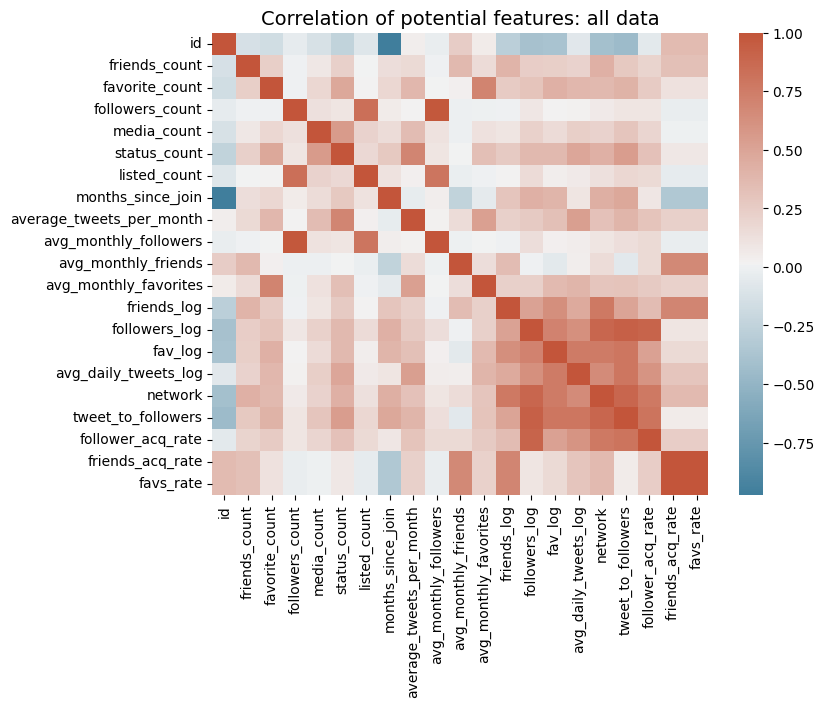

In [46]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include='number')

plt.figure(figsize=(8, 6), dpi=100)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(numeric_columns.corr(), cmap=cmap, annot=False)
plt.title('Correlation of potential features: all data', fontsize=14)
plt.show()

### Bots vs Humans

In [44]:
bots = df[df['account_type'] == 'bot']
humans = df[df['account_type'] == 'human']

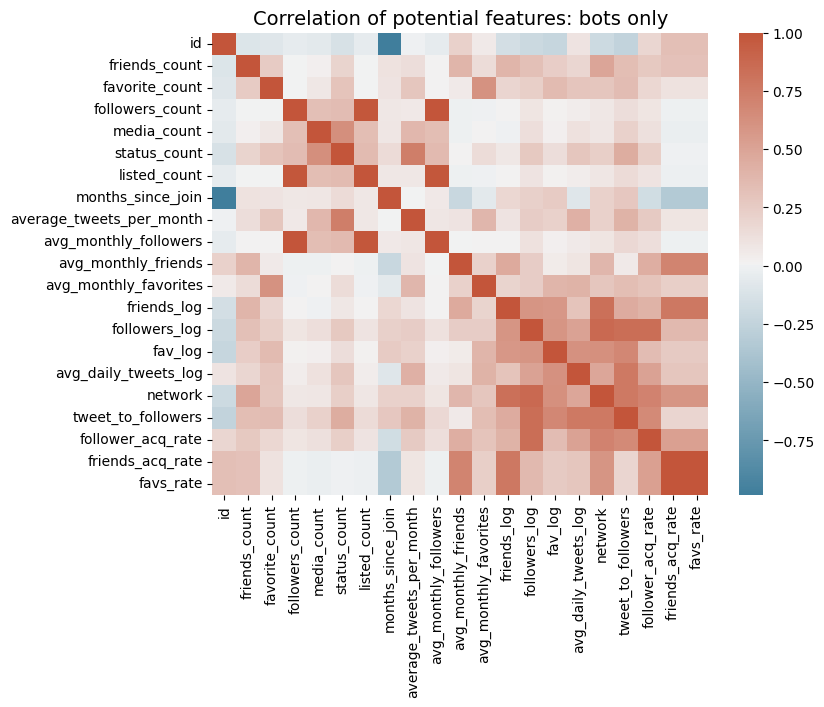

In [47]:
# Select only numeric columns
numeric_columns = bots.select_dtypes(include='number')

plt.figure(figsize=(8, 6), dpi=100)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(numeric_columns.corr(), cmap=cmap, annot=False)
plt.title('Correlation of potential features: bots only', fontsize=14)
plt.show()

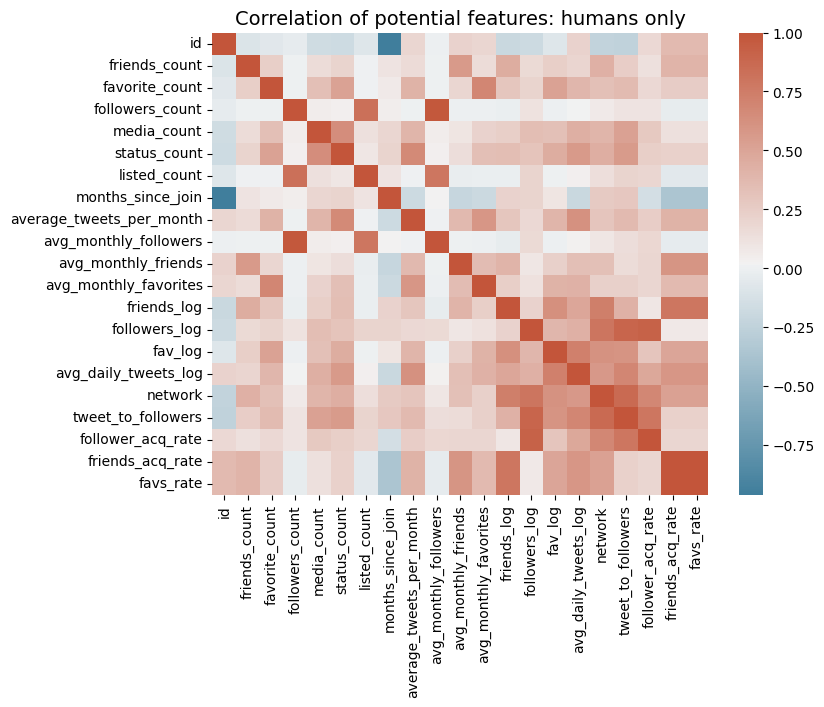

In [48]:
# Select only numeric columns
numeric_columns = humans.select_dtypes(include='number')

plt.figure(figsize=(8, 6), dpi=100)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(numeric_columns.corr(), cmap=cmap, annot=False)
plt.title('Correlation of potential features: humans only', fontsize=14)
plt.show()

## Distribution plots

Now to set up some distribution plots to better understand how some of the features differ between bot and human accounts.  

BOT _ BLUE  
HUMAN _ ORANGE

### Account age

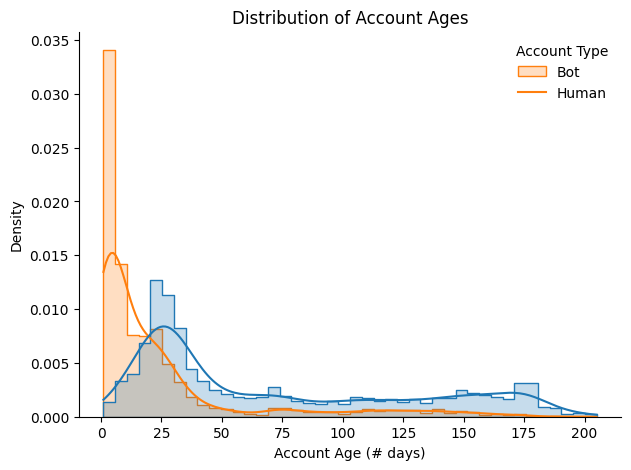

In [69]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='months_since_join', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of Account Ages', fontsize=12)
plt.xlabel('Account Age (# days)', fontsize=10)
plt.ylabel('Density', fontsize=10)
sns.despine()

### Number of followers

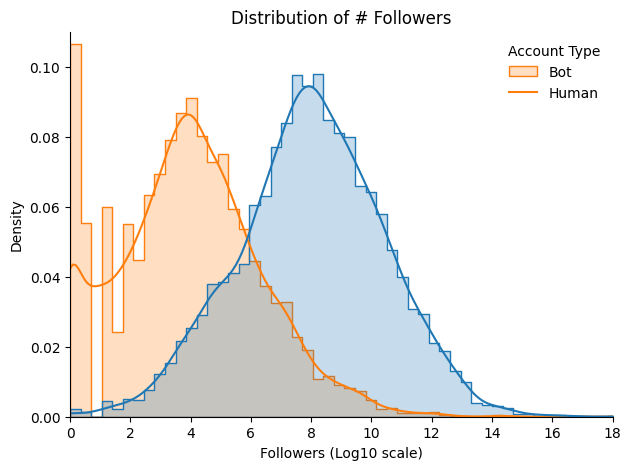

In [71]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='followers_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of # Followers', fontsize=12)
plt.xlabel('Followers (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 18)
plt.ylim(0, 0.11)
sns.despine()
#plt.savefig('imgs/dist_followers.png');

### Number of friends (follow*ing*)

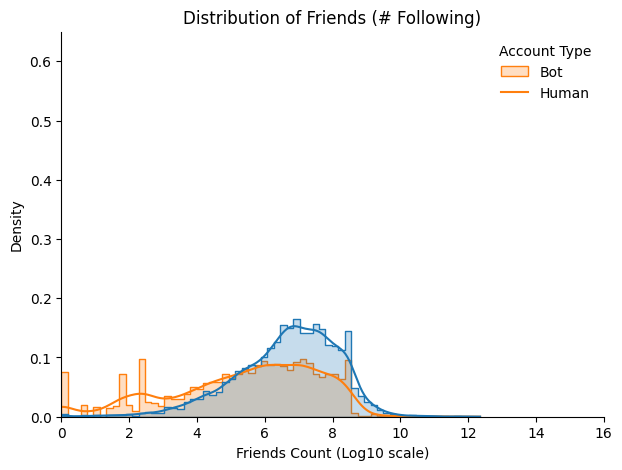

In [72]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='friends_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of Friends (# Following)', fontsize=12)
plt.xlabel('Friends Count (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 16)
plt.ylim(0, 0.65)
sns.despine();

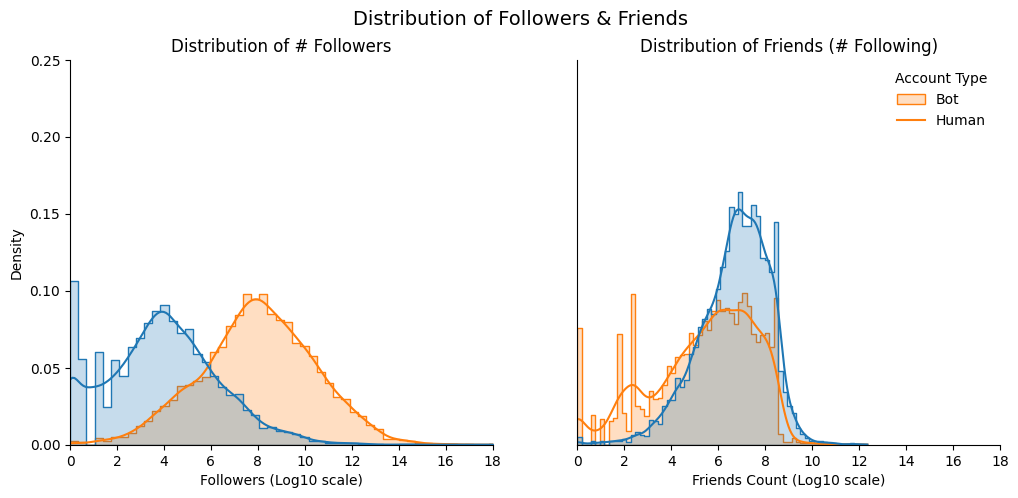

In [73]:
plt.figure(figsize=(12,5), dpi=100)
plt.suptitle('Distribution of Followers & Friends', fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(x='followers_log', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=False)
plt.title('Distribution of # Followers', fontsize=12)
plt.xlabel('Followers (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 18)
plt.ylim(0, 0.25)
sns.despine()

plt.subplot(1, 2, 2)
sns.histplot(x='friends_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of Friends (# Following)', fontsize=12)
plt.xlabel('Friends Count (Log10 scale)', fontsize=10)
plt.ylabel("")
plt.yticks([])
plt.xlim(0, 18)
plt.ylim(0, 0.25)
sns.despine();
#plt.savefig('imgs/dist_followers_friends.png');

### 'Network' Size

Defined as `(number of friends) * (number of followers)` (Log10 scale)

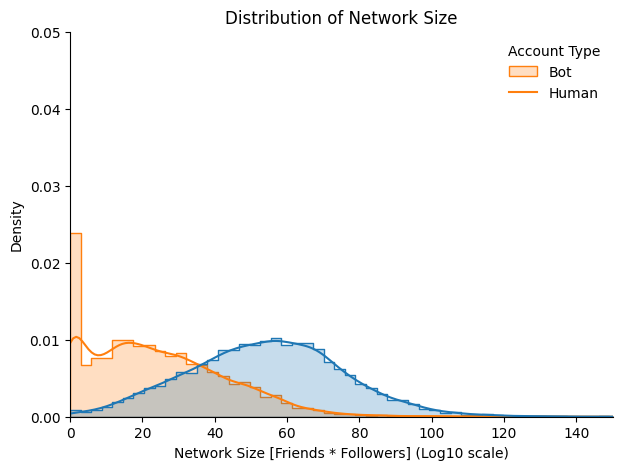

In [74]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='network', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of Network Size', fontsize=12)
plt.xlabel('Network Size [Friends * Followers] (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 150)
plt.ylim(0, 0.05)
sns.despine()
#plt.savefig('imgs/network_size.png');

### Number of favorites

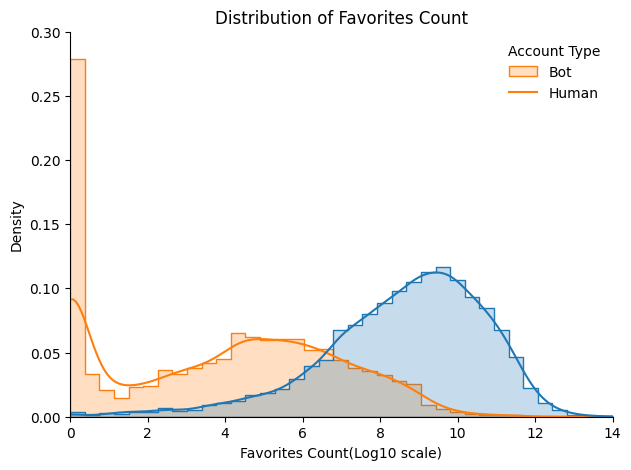

In [75]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='fav_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Distribution of Favorites Count", fontsize=12)
plt.xlabel('Favorites Count(Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 14)
plt.ylim(0, 0.3)
sns.despine()

### Avg tweets per day

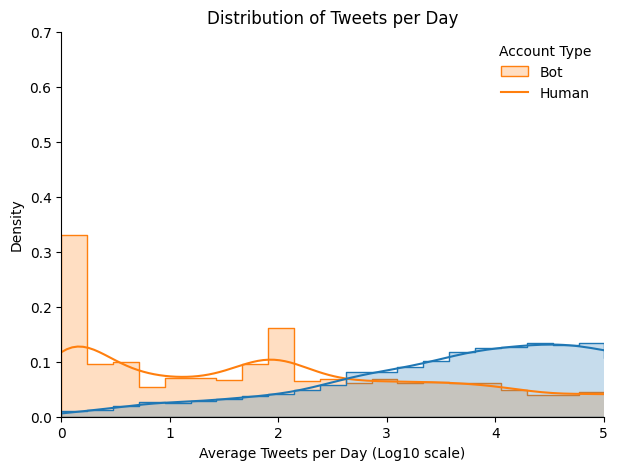

In [77]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='avg_daily_tweets_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Distribution of Tweets per Day", fontsize=12)
plt.xlabel('Average Tweets per Day (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 5)
plt.ylim(0, 0.7)
sns.despine();
#plt.savefig('imgs/tweets_per_day.png');

### Follower acquisition rate

Can be thought of the even cadence rate of new followers per day.

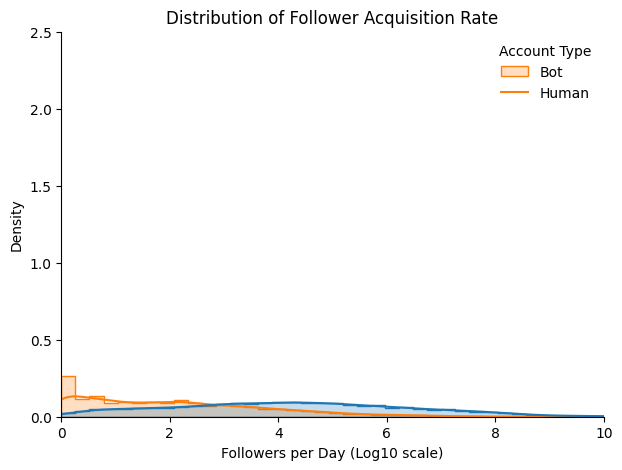

In [78]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='follower_acq_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Distribution of Follower Acquisition Rate", fontsize=12)
plt.xlabel('Followers per Day (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 10)
plt.ylim(0, 2.5)
sns.despine();

### Friends acquisition rate

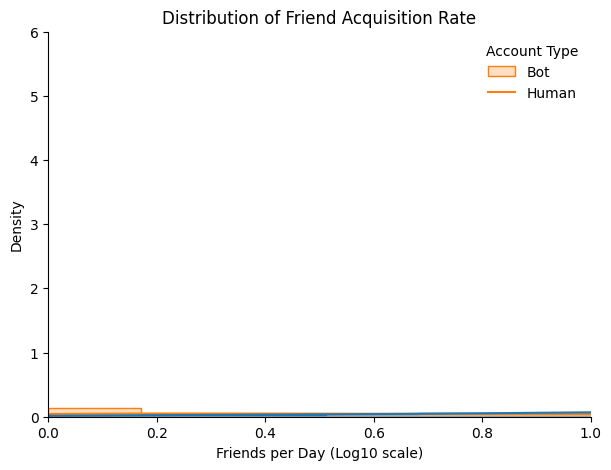

In [79]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='friends_acq_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Distribution of Friend Acquisition Rate", fontsize=12)
plt.xlabel('Friends per Day (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 1)
plt.ylim(0, 6)
sns.despine();

### Tweets to Followers Metric

The idea here is **network *reach*** -- how often they're tweeting and how many people might see it. Since this is a multiplication transformation, the metric will be higher for accounts with a high tweet frequency, high following, or both.

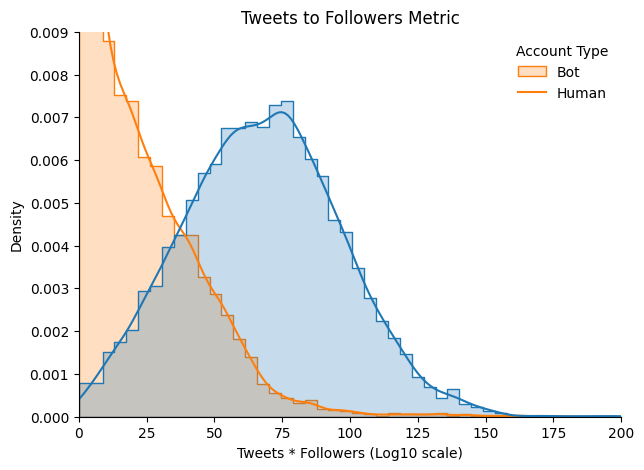

In [80]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='tweet_to_followers', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Tweets to Followers Metric", fontsize=12)
plt.xlabel('Tweets * Followers (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 200)
plt.ylim(0, 0.009)
sns.despine();
#plt.savefig('imgs/tweets_to_followers.png');

## Verification Status

**Verification status** is likely to be a huge feature here. 

From Twitter's website: 
> An account may be verified if it is determined to be an account of public interest. Typically this includes accounts maintained by users in music, acting, fashion, government, politics, religion, journalism, media, sports, business, and other key interest areas.

Verification requires a vetting process and the earlier bar plot with verification status by account type showed that the numbers differ significantly between bot and human accounts. This may not mean that bots are less likely to be verified, however, and may be the result of an imbalanced dataset. Still, it has potential to be a very important feature in the model.